### DATA 620
#### FINAL PROJECT 
### [Video Presentation]()
##### Group Four
- Santosh Cheruku
- Vinicio Haro
- Javern Wilson
- Saayed Alam  

In [315]:
# data processing libraries
import pandas as pd
import numpy as np
from collections import Counter

# network analysis libraries
import networkx as nx
from networkx.algorithms import bipartite as bi

# text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

# visualization librarires
from wordcloud import WordCloud
from mpl_toolkits.basemap import Basemap as Basemap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
% matplotlib inline

# settings
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

#### Introduction 
Social networks is the biggest public forum ever created by mankind and during the time of election, forums are teeming with discussions from negative to positive and everything in between. The conversations create a hub for scientists to analyze texts of large scale and find insights.

Our goal is to perform text mining on over `180,000` tweets from `May 10, 2019` to `May 20, 2019` during **2019 Australian Election**. We will implement *Sentiment Analysis* on tweets to find the overall attitude of the twitter users during the time of election. Next we will apply *Network Analysis* to find Twitter users who are very connected, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network.

#### Dataset 
A summary of the dataset variables:  
`created_at`: Date and time of tweet creation  
`id`: Unique ID of the tweet  
`full_text`: Full tweet text  
`retweet_count`: Number of retweets  
`favorite_count`: Number of likes  
`user_id`: User ID of tweet creator  
`user_name`: Username of tweet creator  
`user_screen_name`: Screen name of tweet creator  
`user_description`: Description on tweet creator's profile  
`user_location`: Location given on tweet creator's profile  
`user_created_at`: Date the tweet creator joined Twitter 

In [304]:
# load dataset
twitter_data = pd.read_csv("auspol2019.csv", parse_dates = ['created_at', 'user_created_at'])

#### Data Exploration
We select the variables necessary for our goals and discard the remainder along with 21 rows of missing values.

In [318]:
# select varaibles
dt = twitter_data.drop(["user_created_at", "user_screen_name", "user_description", "user_location"],
                      axis = 1)

# count row with missing values
dt.isnull().sum()

created_at         0
id                 0
full_text          0
retweet_count      9
favorite_count     9
user_id            9
user_name         21
dtype: int64

In [319]:
# drop na and display data
dt = dt.dropna()
dt.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business


Next, we print the count of unique users, unique tweets, most retweets and most favorite tweets.

In [320]:
# some information about the dataset
print("The dataset has", len(dt.user_id.unique()), "unique users.")
print("And", len(dt.id.unique()), "unique tweets.")
print("The tweet with the most retweets had", dt['retweet_count'].max(), "retweets.")
print("The tweet with the most favorites had", dt['favorite_count'].max(), "favorites.")

The dataset has 45861 unique users.
And 183358 unique tweets.
The tweet with the most retweets had 6622.0 retweets.
The tweet with the most favorites had 15559.0 favorites.


Following Twitter user had this tweet most retweeted and favorited.

In [323]:
# tweet with most retweets and favorites
most_retweet_faves = twitter_data.loc[twitter_data["favorite_count"] == 15559.0]
print(most_retweet_faves.iloc[0][7], ">>>", most_retweet_faves.iloc[0][2])

SaraCarterDC >>> Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd


Next we visualize the number of tweets per day. As expected, the day of the election , `May 18, 2019`, had the highest number of tweets. 

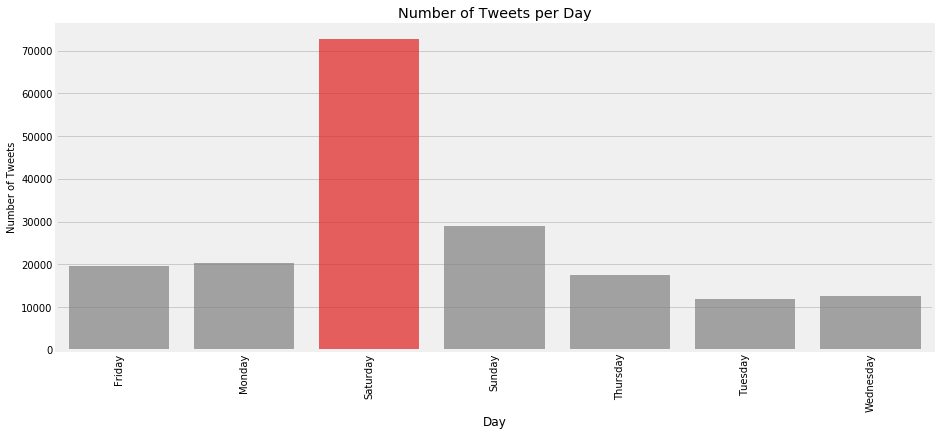

In [325]:
# number of tweets by day
dt['created_at'] =  pd.to_datetime(dt['created_at'])
cnt_srs = dt['created_at'].dt.weekday_name.value_counts()
cnt_srs = cnt_srs.sort_index()

# bar plot of tweets per day
plt.figure(figsize = (14, 6))
clrs = ['grey' if (x < max(cnt_srs.values)) else 'red' for x in cnt_srs.values]
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.7, palette = clrs)

plt.xticks(rotation = 'vertical')
plt.xlabel('Day', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize=10)
plt.title("Number of Tweets per Day")
plt.show()

#### Text Processing
Sentiment analysis, otherwise known as opinion mining is the process of determining the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within an online mention. 

In order to perform sentiment analysis on all the 180,000 tweets, we will have to first clean the dataset.

In [331]:
# get the column with the full tweets
tweets = dt[["full_text"]]

# print first 5 rows
type(tweets)

pandas.core.frame.DataFrame

In [194]:
def tidy_tweet(text):
    stop_words = stopwords.words('english')
    lemma = nltk.WordNetLemmatizer()
    
    hastag = text.str.replace("#[A-Za-z0-9]+", "")
    username = hastag.str.replace("@[A-Za-z0-9]+", "")
    urls = username.str.replace("https?://[A-Za-z0-9./]+", "")
    num_punt = urls.str.replace("[^a-zA-Z]", " ")
    lower_case = num_punt.str.lower()
    token = lower_case.apply(lambda x: x.split())
    stop_words = token.apply(lambda x: [i for i in x if i not in stop_words])
    lemmad = stop_words.apply(lambda x: [lemma.lemmatize(i) for i in x])
    return lemmad

In [186]:
hf_token = tidy_tweet(tweets.full_text)

In [187]:
hf_token.head(10)

0    [climate, election, shellshocked, green, group...
1    [coverage, indian, election, sb, tv, channel, ...
2    [know, facebook, releasing, election, post, mo...
3    [understand, compulsory, preference, system, v...
4    [share, mixed, asia, india, australia, leading...
5    [australia, pollster, review, incorrect, elect...
6    [disappointing, plibersek, ruled, leadership, ...
7    [feel, like, exact, thing, happens, australia,...
8    [quiet, australian, latest, upset, election, f...
9    [conservative, look, set, form, gov, australia...
Name: full_text, dtype: object

In [188]:
# high frequency words
c = Counter()
for i in hf_token:
    c.update(i)
    
hf_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
hf_words.head(10)

,Word,Count
0,election,35402
1,australia,34189
2,vote,24221
3,labor,18521
4,amp,16082
5,party,11716
6,people,11483
7,australian,10938
8,get,9694
9,like,9505


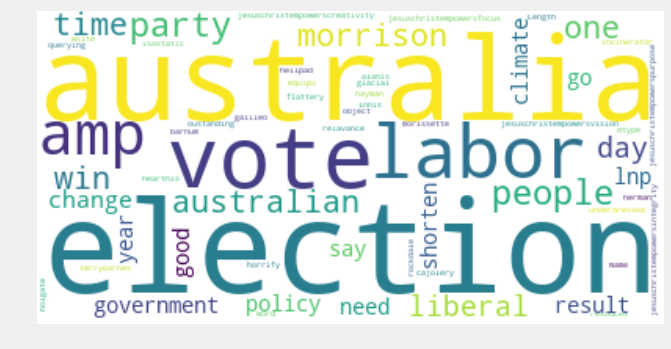

In [189]:
wordcloud = WordCloud(random_state=21, max_words = 100, max_font_size=110, background_color="white").generate(str(hf_words.Word))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

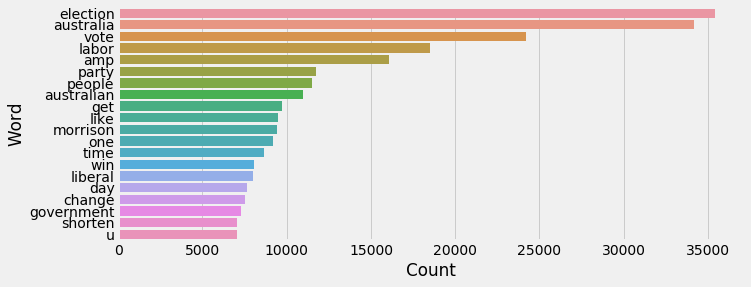

In [190]:
style.use('fivethirtyeight')


figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 4)

sns.barplot(data=hf_words[:20], y="Word", x="Count", ax=ax)

In [191]:
sa = sia()
results = []
tidy_tweet = hf_token.apply(lambda x: " ".join(x))

for i in list(tidy_tweet):
    pol_score = sa.polarity_scores(i)
    pol_score['tweet'] = i
    results.append(pol_score)
    
sa_score = pd.DataFrame.from_records(results)
sa_score.head()

,compound,neg,neu,pos,tweet
0,0.2732,0.000,0.741,0.259,climate election shellshocked green group rema...
1,0.0000,0.000,1.000,0.000,coverage indian election sb tv channel austral...
2,-0.1531,0.169,0.704,0.127,know facebook releasing election post mortem a...
3,-0.2755,0.117,0.883,0.000,understand compulsory preference system vote g...
4,0.6808,0.000,0.699,0.301,share mixed asia india australia leading gain ...


In [192]:
sa_score['label'] = 0
sa_score.loc[sa_score['compound'] > 0.2, 'label'] = 1
sa_score.loc[sa_score['compound'] < -0.2, 'label'] = -1
sa_score.head()

,compound,neg,neu,pos,tweet,label
0,0.2732,0.000,0.741,0.259,climate election shellshocked green group rema...,1
1,0.0000,0.000,1.000,0.000,coverage indian election sb tv channel austral...,0
2,-0.1531,0.169,0.704,0.127,know facebook releasing election post mortem a...,0
3,-0.2755,0.117,0.883,0.000,understand compulsory preference system vote g...,-1
4,0.6808,0.000,0.699,0.301,share mixed asia india australia leading gain ...,1


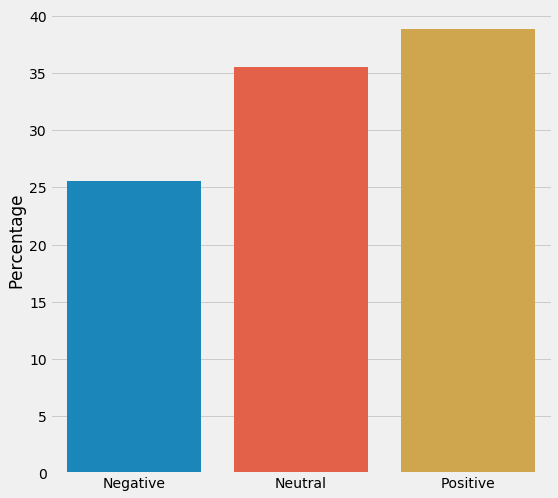

In [193]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = sa_score.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [195]:
pos_tweets = sa_score[sa_score.label == 1].tweet
pos_words = tidy_tweet(pos_tweets)

# high frequency words
c = Counter()
for i in pos_words:
    c.update(i)
    
posi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
posi_words.head(10)

,Word,Count
0,election,15532
1,australia,15305
2,vote,11083
3,party,8710
4,labor,8068
5,amp,7331
6,win,6854
7,like,6513
8,good,5235
9,people,5068


In [196]:
neg_tweets = sa_score[sa_score.label == -1].tweet
neg_words = tidy_tweet(neg_tweets)

# high frequency words
c = Counter()
for i in neg_words:
    c.update(i)
    
negi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
negi_words.head(10)

,Word,Count
0,australia,8644
1,election,8302
2,labor,5682
3,amp,5642
4,vote,5622
5,people,4165
6,australian,2976
7,get,2847
8,climate,2689
9,one,2579


In [197]:
posi_words[np.logical_not(posi_words.Word.isin(negi_words.Word))].head(10)

,Word,Count
355,seizes,454
493,celebrates,317
775,damien,202
1618,poised,83
2678,npr,44
2843,delighted,40
2958,wilt,38
3704,appreciated,26
3756,inspirational,26
3812,azerbaijan,25


In [198]:
negi_words[np.logical_not(negi_words.Word.isin(posi_words.Word))].head(10)

,Word,Count
2976,thinkprogress,28
3199,nonexistent,26
3428,jailed,23
3482,gloom,22
3652,laborout,21
3699,forecaster,20
3886,evades,19
4001,harassing,18
4017,uproar,18
4113,reek,17


### Network Analysis

In [274]:
full_tweet = pd.concat([dt, sa_score[["tweet", "label"]]], axis = 1)

In [275]:
#full_tweet['user_id'] = full_tweet['user_id'].apply(np.int64)
full_tweet = full_tweet.dropna()
full_tweet['user_id'] = full_tweet['user_id'].apply(np.int64)
full_tweet.head()

,user_id,user_name,full_text,id,retweet_count,favorite_count,tweet,label
0,92484856,PIPELINEPETE,After the climate election: shellshocked green...,1130401208756187136,0.0,0.0,climate election shellshocked green group rema...,1.0
1,775647396,Narinder Parmar,@narendramodi @smritiirani Coverage of indian ...,1130401205367140357,0.0,0.0,coverage indian election sb tv channel austral...,0.0
2,56873,Peter Wells,@workmanalice Do you know if Facebook is relea...,1130401162782371841,0.0,0.0,know facebook releasing election post mortem a...,0.0
3,908166034045026304,The Realist,@vanbadham We all understand we have a compuls...,1130401143551434753,0.0,0.0,understand compulsory preference system vote g...,-1.0
4,526007385,Inquirer Business,"Shares were mixed in Asia, with India and Aust...",1130401118666809345,0.0,0.0,share mixed asia india australia leading gain ...,1.0


In [276]:
postive_tweets = full_tweet.loc[full_tweet["label"] == 1]

In [277]:
negative_tweets = full_tweet.loc[full_tweet["label"] == -1]

In [278]:
postive_tweets.head()

,user_id,user_name,full_text,id,retweet_count,favorite_count,tweet,label
0,92484856,PIPELINEPETE,After the climate election: shellshocked green...,1130401208756187136,0.0,0.0,climate election shellshocked green group rema...,1.0
4,526007385,Inquirer Business,"Shares were mixed in Asia, with India and Aust...",1130401118666809345,0.0,0.0,share mixed asia india australia leading gain ...,1.0
7,2271271897,Jaz Jubilee,@robynesc I feel like this exact thing happens...,1130400889997385728,0.0,0.0,feel like exact thing happens australia people...,1.0
10,1721130294,Gary Fallon,"#auspol Hear, bloody hear. Any party that oppo...",1130400637487702016,1.0,2.0,hear bloody hear party opposes relentlessly gr...,1.0
11,3045738188,Ice Maiden,Comment: Losing the unlosable election: the af...,1130400598279352320,0.0,0.0,comment losing unlosable election aftermath la...,1.0


In [279]:
negative_tweets.head()

,user_id,user_name,full_text,id,retweet_count,favorite_count,tweet,label
3,908166034045026304,The Realist,@vanbadham We all understand we have a compuls...,1130401143551434753,0.0,0.0,understand compulsory preference system vote g...,-1.0
6,51002583,Matthew Rimmer,It is disappointing that @tanya_plibersek has ...,1130401009782673408,0.0,0.0,disappointing plibersek ruled leadership chall...,-1.0
8,1740060962,Moved,'Quiet Australians' are the latest to upset el...,1130400789694885888,0.0,0.0,quiet australian latest upset election forecas...,-1.0
17,228310395,EG YIK FAN 吴益帆,#财经视野 #BIZpective\nAustralia election just ove...,1130399752527306752,0.0,0.0,australia election australian dollar perform h...,-1.0
18,1118532228886040576,markasher224,BBC News - 2019 Australia election: Morrison's...,1130399591986155522,0.0,0.0,bbc news australia election morrison coalition...,-1.0


In [280]:
P = nx.from_pandas_dataframe(postive_tweets , 'user_id', 'id', edge_attr = ['retweet_count', 'favorite_count'], create_using=nx.Graph())
print(nx.info(P))

Name: 
Type: Graph
Number of nodes: 97382
Number of edges: 71261
Average degree:   1.4635


In [283]:
#degree centrality
degree_c = nx.degree_centrality(P)
degree_c_df = pd.DataFrame([degree_c.values()], columns=degree_c.keys()).T.reset_index()
degree_c_df.rename(columns ={0:'Degree Centrality','index': 'Nodes'}, inplace = True)
degree_c_df.sort_values(['Degree Centrality'], ascending=False, inplace = True)
degree_c_df.head()

,Nodes,Degree Centrality
44430,373149557,0.003522
24376,1126229447252647936,0.002044
783,1706358680,0.001766
25407,3898426152,0.001674
16098,485497413,0.001294


In [285]:
influencer = full_tweet.loc[full_tweet["user_id"] == 373149557]

In [294]:
N = nx.from_pandas_dataframe(negative_tweets, 'user_id', 'id', edge_attr = ['retweet_count', 'favorite_count'], create_using=nx.Graph())
print(nx.info(N))

Name: 
Type: Graph
Number of nodes: 65349
Number of edges: 46866
Average degree:   1.4343


In [295]:
#degree centrality
degree_c = nx.degree_centrality(N)
degree_c_df = pd.DataFrame([degree_c.values()], columns=degree_c.keys()).T.reset_index()
degree_c_df.rename(columns ={0:'Degree Centrality','index': 'Nodes'}, inplace = True)
degree_c_df.sort_values(['Degree Centrality'], ascending=False, inplace = True)
degree_c_df.head()

,Nodes,Degree Centrality
10744,373149557,0.003458
4526,1559468120,0.002647
13310,1126229447252647936,0.001959
12696,3898426152,0.001775
433,1706358680,0.001637
